In [4]:
import requests
import json
import time
import os
from dotenv import load_dotenv
import pandas as pd 
from queries import * 
load_dotenv()

class Flipsider:
    def __init__(self, API_KEY, TTL_MINUTES=60*24):
        self.API_KEY = API_KEY
        self.TTL_MINUTES = TTL_MINUTES

    def create_query(self, SQL_QUERY):
        r = requests.post(
            'https://node-api.flipsidecrypto.com/queries', 
            data=json.dumps({
                "sql": SQL_QUERY,
                "ttlMinutes": self.TTL_MINUTES
            }),
            headers={"Accept": "application/json", "Content-Type": "application/json", "x-api-key": self.API_KEY},
        )
        if r.status_code != 200:
            raise Exception("Error creating query, got response: " + r.text + "with status code: " + str(r.status_code))

        return json.loads(r.text)    


    def get_query_results(self, token):
        r = requests.get(
            'https://node-api.flipsidecrypto.com/queries/' + token, 
            headers={"Accept": "application/json", "Content-Type": "application/json", "x-api-key": self.API_KEY}
        )
        if r.status_code != 200:
            raise Exception("Error getting query results, got response: " + r.text + "with status code: " + str(r.status_code))
        
        data = json.loads(r.text)
        if data['status'] == 'running':
            time.sleep(10)
            return self.get_query_results(token)

        return data


    def run(self, SQL_QUERY):
        query = self.create_query(SQL_QUERY)
        token = query.get('token')
        data = self.get_query_results(token)
        df = pd.DataFrame(data['results'],columns = data['columnLabels'])
        return df

def load_queries():
    bot = Flipsider(os.getenv('API_KEY'))
    df = bot.run(SQL_QUERY)
    df_images = bot.run(IMAGE_QUERY)
    df_minted = bot.run(MINTED_QUERY)
    return df, df_images, df_minted

In [6]:
# Daily New Addresses on Polygon Overtime
# https://app.flipsidecrypto.com/velocity/queries/2124494c-5ce5-4639-94a1-777f713f46dd
QUERY = """with new_poly as (
  select from_address as address , min(block_timestamp)::date as min_date
  from flipside_prod_db.polygon.transactions
  group by address

)  
  select count(address) as new_address, min_date,
  	sum(new_address) over (order by min_date asc rows between unbounded preceding and current row) as cumulative_address  
  from new_poly group by min_date""" 

In [7]:
bot = Flipsider(os.getenv('API_KEY'))

In [8]:
df = bot.run(QUERY)
df.head()

,NEW_ADDRESS,MIN_DATE,CUMULATIVE_ADDRESS
0,3,2020-05-30,3
1,1,2020-06-12,4
2,2,2020-06-18,6
3,2,2020-06-19,8
4,6,2020-06-20,14


In [11]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [129]:

def plot_new_addresses(df,x0='NEW_ADDRESS',x1='CUMULATIVE_ADDRESS'):
    df['MIN_DATE']  =pd.to_datetime(df['MIN_DATE'])
    random_x = df['MIN_DATE'].tolist()
    random_y0 = df[x0].tolist()
    random_y1 = df[x1].tolist()

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Bar(x=random_x, y=random_y0,
                        #mode='lines',
                        name=x0.capitalize().replace('_', ' ')),secondary_y=True)
    fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                        mode='lines',
                        name=x1.capitalize().replace('_', ' ')),secondary_y=False)

    fig.update_yaxes(title_text="New Addresses", secondary_y=True)
    fig.update_yaxes(title_text="Total Addresses", secondary_y=False)
    fig.update_layout(hovermode="x")
    fig.update_layout(barmode='stack', bargap=0.0,bargroupgap=0.0)
    fig.update_traces(marker_line_width=0)

    return fig

def plot_average_new_addresses_per_day(df2):
    fig =  px.bar(data_frame=df2.sort_values(by='TYPE'),x='TYPE',y='NEW_ADDRESS')
    return fig

def plot_active_addresses(df3):
    df3 = df3.melt()
    fig =  px.bar(data_frame=df3,x='variable',y='value')
    return fig

def plot_active_addresses(df,x0='USERS_DOING_TRANSACTIONS',x1='MATIC_PRICE',x2='USERS_RECEIVING_TOKENS'):
    df['DATE']  =pd.to_datetime(df['DATE'])
    random_x = df['DATE'].tolist()
    random_y0 = df[x0].tolist()
    random_y1 = df[x1].tolist()
    random_y2 = df[x2].tolist()

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Bar(x=random_x, y=random_y0,
                         offsetgroup=0,
                        #mode='lines',
                        name=x0.capitalize().replace('_', ' ')),secondary_y=False)

    fig.add_trace(go.Bar(x=random_x, y=random_y2,
                         offsetgroup=0,
                         base=random_y0,
                        #mode='lines',
                        name=x2.capitalize().replace('_', ' ')),secondary_y=False)

    fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                        mode='lines',
                        name=x1.capitalize().replace('_', ' ')),secondary_y=True)

    fig.update_yaxes(title_text="MATIC Price", secondary_y=True)
    fig.update_yaxes(title_text="Active Users", secondary_y=False)
    fig.update_layout(hovermode="x")
    fig.update_layout(barmode='stack', bargap=0.0,bargroupgap=0.0)
    fig.update_traces(marker_line_width=0)
    return fig


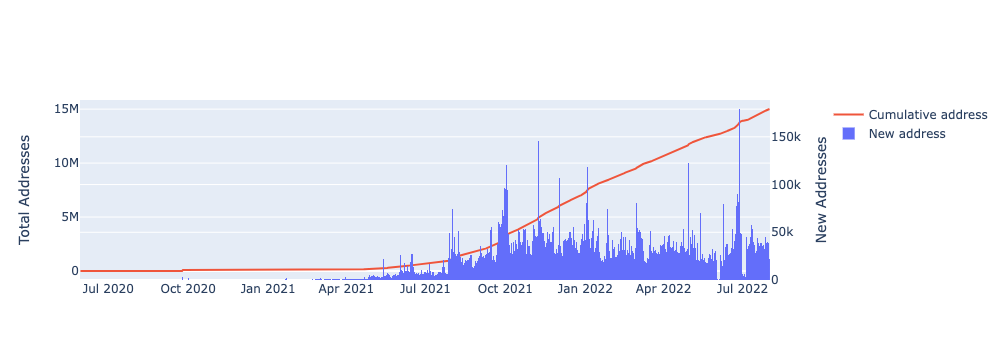

In [130]:
plot_new_addresses(df,x0='NEW_ADDRESS',x1='CUMULATIVE_ADDRESS')

In [34]:
QUERY2 = """with new_poly_2020 as (
  select from_address as address , min(block_timestamp)::date as min_date, '2020' as type
  from flipside_prod_db.polygon.transactions
  group by address
    having min_date <= '2020-12-31' and min_date >= '2020-01-01'
)  , new_poly_2021 as (
  select from_address as address , min(block_timestamp)::date as min_date, '2021' as type
  from flipside_prod_db.polygon.transactions
  group by address
    having min_date <= '2021-12-31' and min_date >= '2021-01-01'
)  , new_poly_2022 as (
  select from_address as address , min(block_timestamp)::date as min_date, '2022' as type
  from flipside_prod_db.polygon.transactions
  group by address
    having min_date >= '2022-01-01' and min_date <= '2022-05-29'
)  
  select count(address)/365 as new_address, type
  from new_poly_2020 group by  type
	UNION
  select count(address)/365  as new_address,  type
  from new_poly_2021 group by  type
	UNION
  select count(address)/datediff(day, '2022-01-01', '2022-05-29') as new_address,  type
  from new_poly_2022 group by  type"""

In [35]:
df2 = bot.run(QUERY2)
df2.head()

,NEW_ADDRESS,TYPE
0,19441.282192,2021
1,304.887671,2020
2,36554.067568,2022


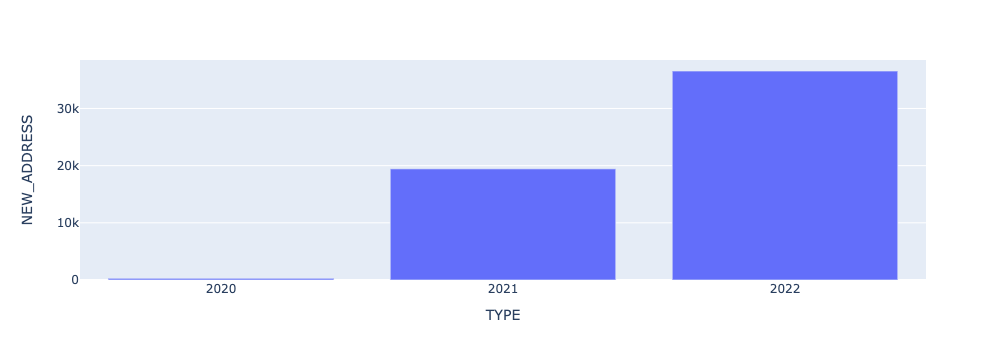

In [40]:
plot_average_new_addresses_per_day(df2)

In [46]:
QUERY3 = """WITH
  active_users as (
  SELECT
  distinct from_address as active_user--,
  --max(block_timestamp) as last_transaction
  from flipside_prod_db.polygon.transactions
  where block_timestamp>=CURRENT_DATE-INTERVAL '3 MONTHS'
  group by 1
  ),
  active_users_n as (
  select count (distinct active_user) as active_users_doing_transactions from active_users
  ),
active_users_2 as (
  SELECT
  distinct to_address as active_receiver--,
  --max(block_timestamp) as last_transaction
  from flipside_prod_db.polygon.transactions --where to_address not in (select active_user from active_users)
  where block_timestamp>=CURRENT_DATE-INTERVAL '3 MONTHS'
  group by 1
),
  active_users_21 as (
  SELECT
  count(distinct active_receiver) as active_users_receiving_tokens--,
  --last_transaction
  from active_users_2 
  where active_receiver not in (select active_user from active_users)
)
select 
active_users_doing_transactions,
active_users_receiving_tokens,
active_users_doing_transactions+active_users_receiving_tokens as current_total_active_users
from active_users_n, active_users_21"""
df3 = bot.run(QUERY3)
df3.head()

,ACTIVE_USERS_DOING_TRANSACTIONS,ACTIVE_USERS_RECEIVING_TOKENS,CURRENT_TOTAL_ACTIVE_USERS
0,5101507,986340,6087847


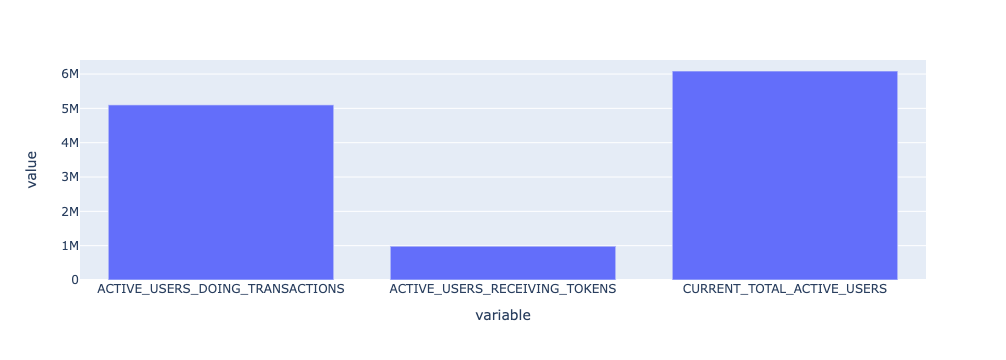

In [45]:
plot_active_addresses(df3)

In [47]:
QUERY4 = """-- How many addresses on the MATIC network are active? What’s the daily evolution of active addresses? Is the activeness related some how to the price?
-- Hint: Active address is an address that has done at least one transaction or has received at least once a token in the past 3 months.
WITH
  active_users_n as (
  SELECT
  trunc(block_timestamp,'day') as date,
  count(distinct from_address) as active_users
  from flipside_prod_db.polygon.transactions
  group by 1
  ),
active_users_2_n as (
  SELECT
  trunc(block_timestamp,'day') as date,
  count(distinct to_address) as active_users
  from flipside_prod_db.polygon.transactions
  group by 1
),
price as (
  SELECT
  trunc(hour,'day') as date,
  avg(price) as price
  from flipside_prod_db.ethereum_core.fact_hourly_token_prices
  where symbol='MATIC'
  GROUP BY 1
  order by 1 ASC
  )
SELECT
x.date,
x.active_users as users_doing_transactions, y.active_users as users_receiving_tokens,
price as matic_price
from active_users_n x, active_users_2_n y, price z where x.date=y.date and x.date=z.date 
order by 1 asc"""
df4 = bot.run(QUERY4)
df4.head()

,DATE,USERS_DOING_TRANSACTIONS,USERS_RECEIVING_TOKENS,MATIC_PRICE
0,2020-05-30 00:00:00.000,3,7,0.025052
1,2020-06-12 00:00:00.000,3,4,0.020170
2,2020-06-15 00:00:00.000,3,3,0.019905
3,2020-06-16 00:00:00.000,1,1,0.020487
4,2020-06-18 00:00:00.000,4,4,0.020549


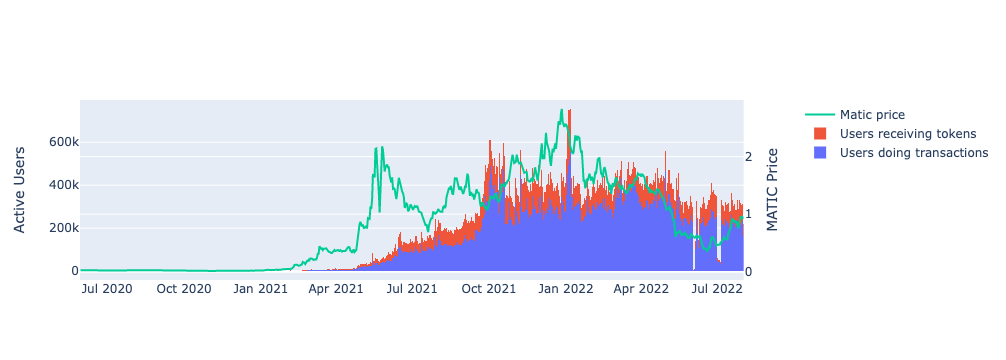

In [131]:
plot_active_addresses(df4,x0='USERS_DOING_TRANSACTIONS',x1='MATIC_PRICE',x2='USERS_RECEIVING_TOKENS')

In [75]:
QUERY5 = """with cs as (
  select 
  		BALANCE_DATE as date,
		sum(balance) as circulating_supply,
        Count(user_address) as holders
  from flipside_prod_db.ethereum.erc20_balances
  	where 
  		CONTRACT_ADDRESS = lower('0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0')
 	and USER_ADDRESS not in ('0x50d669f43b484166680ecc3670e4766cdb0945ce', '0xcbfe11b78c2e6cb25c6eda2c6ff46cd4755c8fca',
  							'0xb316fa9fa91700d7084d377bfdc81eb9f232f5ff', '0xccb04768f3abcf1af1e749085ef67d8ec7c5fdd2','0x5e3ef299fddf15eaa0432e6e66473ace8c13d908')
group by date 
  ),
price as (
  select 
  		date_trunc('day', HOUR) as date,
  		avg(PRICE) as matic_average_price
  from flipside_prod_db.ethereum.token_prices_hourly
  	where TOKEN_ADDRESS = lower('0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0')
  group by date
)
select 
  	cs.date,
	cs.circulating_supply * p.matic_average_price as Market_Cap,
	p.matic_average_price,
  	cs.circulating_supply,
    cs.holders
from cs join price p on cs.date = p.date
"""
df5 = bot.run(QUERY5)
df5.head()

,DATE,MARKET_CAP,MATIC_AVERAGE_PRICE,CIRCULATING_SUPPLY,HOLDERS
0,2021-06-12,6.492962e+09,1.262222,5.144072e+09,71795
1,2021-08-09,5.926548e+09,1.106647,5.355410e+09,109455
2,2020-06-06,6.731381e+07,0.020596,3.268217e+09,3361
3,2022-04-30,7.376598e+09,1.127330,6.543423e+09,403928
4,2022-06-01,4.296859e+09,0.633987,6.777523e+09,421522


In [136]:
def plot_marketcap(df,x0='MARKET_CAP',x1='MATIC_AVERAGE_PRICE',x2='CIRCULATING_SUPPLY'):
    df = df.sort_values('DATE')
    df['DATE']  =pd.to_datetime(df['DATE'])
    random_x = df['DATE'].tolist()
    random_y0 = df[x0].tolist()
    random_y1 = df[x1].tolist()
    random_y2 = df[x2].tolist()

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])


    fig.add_trace(go.Bar(x=random_x, y=random_y2,
                         offsetgroup=1,
                         # base=random_y0,
                        #mode='lines',
                        name=x2.capitalize().replace('_', ' ')),secondary_y=False)

    
    fig.add_trace(go.Bar(x=random_x, y=random_y0,
                         offsetgroup=0,
                        #mode='lines',
                        name=x0.capitalize().replace('_', ' ')),secondary_y=False)
    
    fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                        mode='lines',
                        name=x1.capitalize().replace('_', ' ')),secondary_y=True)

    fig.update_yaxes(title_text="MATIC Price", secondary_y=True)
    fig.update_yaxes(title_text="Supply/Cap", secondary_y=False)
    fig.update_layout(hovermode="x")
    fig.update_layout(height=300, paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    fig.update_layout(barmode='group', bargap=0.0,bargroupgap=0.0)
    fig.update_traces(marker_line_width=0)
#    fig.update_traces(#marker_color='rgb(158,202,225)', 
#                      marker_line_color='rgb(8,48,107)',
#                  marker_line_width=1.5, opacity=0.6)

    return fig

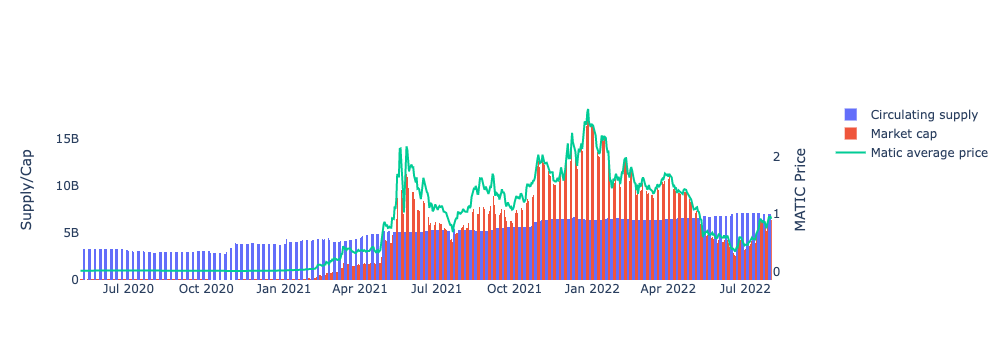

In [137]:
plot_marketcap(df5,x0='MARKET_CAP',x1='MATIC_AVERAGE_PRICE',x2='CIRCULATING_SUPPLY')

In [74]:
QUERY6 = """WITH
polygon AS (
	SELECT
		DATE_TRUNC('day', hour) AS date,
		ROUND(AVG(txn)) AS avg_txn,
        AVG(fee) AS fees
	FROM (
		SELECT
			DATE_TRUNC('hour', block_timestamp) AS hour,
			COUNT(tx_id) AS txn,
            sum(fee) AS fee
		FROM
			flipside_prod_db.polygon.transactions
		WHERE
			block_timestamp::date >= '2021-09-01'
		GROUP BY
			hour
	)
	GROUP BY
		date
	ORDER BY
		date
)
SELECT
*   
FROM
	polygon
"""
df6 = bot.run(QUERY6)
df6.head()

,DATE,AVG_TXN,FEES
0,2021-09-01 00:00:00.000,268396,975.811882
1,2021-09-02 00:00:00.000,271486,907.734670
2,2021-09-03 00:00:00.000,258679,821.471363
3,2021-09-04 00:00:00.000,244522,786.009645
4,2021-09-05 00:00:00.000,230124,750.346548


In [125]:
def plot_fees(df,x0='AVG_TXN',x2='FEES'):
    df = df.sort_values('DATE')
    df['DATE']  =pd.to_datetime(df['DATE'])
    random_x = df['DATE'].tolist()
    random_y0 = df[x0].tolist()
    random_y2 = df[x2].tolist()

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Bar(x=random_x, y=random_y0,
                         offsetgroup=0,
                        #mode='lines',
                        name=x0.capitalize().replace('_', ' ')),secondary_y=False)

    fig.add_trace(go.Bar(x=random_x, y=random_y2,
                         offsetgroup=1,
                         # base=random_y0,
                        #mode='lines',
                        name=x2.capitalize().replace('_', ' ')),secondary_y=True)

    fig.update_yaxes(title_text="Average Fees", secondary_y=True)
    fig.update_yaxes(title_text="Average Transactions", secondary_y=False)
    fig.update_layout(hovermode="x")
    fig.update_layout(height=300, paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    fig.update_layout(barmode='stack', bargap=0.0,bargroupgap=0.0)
    fig.update_traces(marker_line_width=0)
#    fig.update_traces(#marker_color='rgb(158,202,225)', 
#                      marker_line_color='rgb(8,48,107)',
#                  marker_line_width=1.5, opacity=0.6)

    return fig

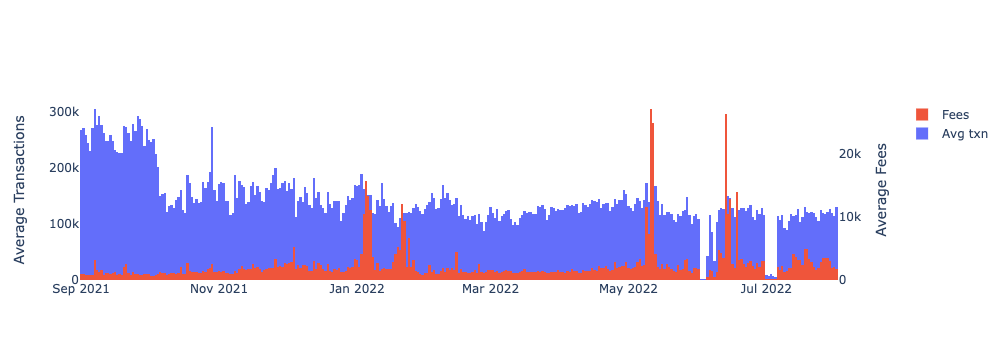

In [126]:
plot_fees(df6,x0='AVG_TXN',x2='FEES')